In [1]:
!pip install --upgrade git+https://github.com/ariaghora/mpstemmer.git
!pip install python-Levenshtein

  Cloning https://github.com/ariaghora/mpstemmer.git to /tmp/pip-req-build-5w5zouwq
  Running command git clone --filter=blob:none --quiet https://github.com/ariaghora/mpstemmer.git /tmp/pip-req-build-5w5zouwq
  Resolved https://github.com/ariaghora/mpstemmer.git to commit 25a5fd923af163a7eac3a5ec976984156ca8fa8b
  Preparing metadata (setup.py) ... done
  Created wheel for mpstemmer: filename=mpstemmer-0.1.0-py3-none-any.whl size=99799 sha256=da2f87986ecddd2bdabc1f8fddf08e5299d96090f82fed78382b28e7931973bb
  Stored in directory: /tmp/pip-ephem-wheel-cache-ildv9a7n/wheels/85/1f/78/fccc1e7e90613593e0a66304a3711d678e3013034d91534182
Successfully built mpstemmer
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 47.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import json
import requests
import csv
from io import StringIO
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt_tab')
from mpstemmer import MPStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [3]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.1 MB/s eta 0:00:00


In [4]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [5]:
app_reviews_df = pd.read_csv('duolingo_reviews.csv')

jumlah_ulasan, jumlah_kolom = app_reviews_df.shape
print(f"Jumlah ulasan: {jumlah_ulasan}")
print(f"Jumlah kolom: {jumlah_kolom}")

Jumlah ulasan: 18000
Jumlah kolom: 11


In [6]:
app_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,fc0ad312-a83f-4de3-a00e-5e90e349f41c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"aplikasi nya bagus banget, sangat² membantu ta...",5,265,6.50.2,2025-10-04 20:51:53,NaN,NaN,6.50.2
1,d1a1d5fd-b1d3-4e79-8b7a-78189e2859d6,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Aplikasinya bagus. Jadi lebih bervariasi denga...,2,30,6.50.2,2025-10-07 16:00:06,NaN,NaN,6.50.2
2,538dc808-8c1d-4fbd-9644-b7f85582067e,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,DUOLINGO SERU ABIS. bukan cuma latihan bahasa ...,5,1,6.51.4,2025-10-12 14:47:55,NaN,NaN,6.51.4
3,1eb014f4-fdee-49e2-8aed-47641f157afd,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,⭐ ⭐ ⭐ ⭐ ⭐ aplikasi fav aku bgt buat belajar ba...,5,1246,6.48.4,2025-09-17 14:15:29,NaN,NaN,6.48.4
4,028adc24-1c59-4d49-bf81-3f07b3ad6333,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"sukaakk poll sama apk belajar ini, sempet pind...",5,180,6.50.2,2025-10-01 12:57:31,NaN,NaN,6.50.2


In [7]:
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reviewId              18000 non-null  object 
 1   userName              18000 non-null  object 
 2   userImage             18000 non-null  object 
 3   content               18000 non-null  object 
 4   score                 18000 non-null  int64  
 5   thumbsUpCount         18000 non-null  int64  
 6   reviewCreatedVersion  17335 non-null  object 
 7   at                    18000 non-null  object 
 8   replyContent          0 non-null      float64
 9   repliedAt             0 non-null      float64
 10  appVersion            17335 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 1.5+ MB


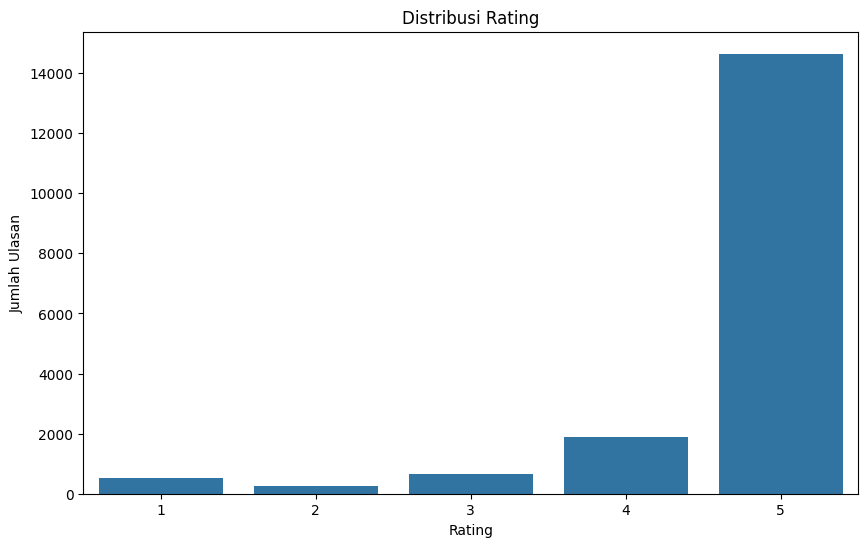

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(x='score', data=app_reviews_df)
plt.title('Distribusi Rating')
plt.xlabel('Rating')
plt.ylabel('Jumlah Ulasan')
plt.show()

## **Pre-Processing**

In [9]:
app_reviews_df.isnull().sum()

,0
reviewId,0
userName,0
userImage,0
content,0
score,0
thumbsUpCount,0
reviewCreatedVersion,665
at,0
replyContent,18000
repliedAt,18000


In [10]:
app_reviews_df = app_reviews_df.drop(columns=['replyContent', 'repliedAt'])

app_reviews_df['reviewCreatedVersion'].fillna('Unknown', inplace=True)
app_reviews_df['appVersion'].fillna('Unknown', inplace=True)

app_reviews_df.isnull().sum()

/tmp/ipython-input-1171348905.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  app_reviews_df['reviewCreatedVersion'].fillna('Unknown', inplace=True)
/tmp/ipython-input-1171348905.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, 

,0
reviewId,0
userName,0
userImage,0
content,0
score,0
thumbsUpCount,0
reviewCreatedVersion,0
at,0
appVersion,0


In [11]:
clean_df = app_reviews_df.drop_duplicates()
clean_df.duplicated().sum()

np.int64(0)

In [12]:
jumlah_ulasan_setelah_hapus_duplikat, jumlah_kolom_setelah_hapus_duplikat = clean_df.shape

print(f"Jumlah ulasan sebelum menghapus duplikat: {jumlah_ulasan}")
print(f"Jumlah ulasan setelah menghapus duplikat: {jumlah_ulasan_setelah_hapus_duplikat}")
print(f"Jumlah kolom: {jumlah_kolom_setelah_hapus_duplikat}")

Jumlah ulasan sebelum menghapus duplikat: 18000
Jumlah ulasan setelah menghapus duplikat: 18000
Jumlah kolom: 9


In [13]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              18000 non-null  object
 1   userName              18000 non-null  object
 2   userImage             18000 non-null  object
 3   content               18000 non-null  object
 4   score                 18000 non-null  int64 
 5   thumbsUpCount         18000 non-null  int64 
 6   reviewCreatedVersion  18000 non-null  object
 7   at                    18000 non-null  object
 8   appVersion            18000 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.2+ MB


In [14]:
# pakai sastrawi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# ambil kamus slang dari github
url_slang = "https://raw.githubusercontent.com/onpilot/sentimen-bahasa/master/kamus/nasalsabila_kamus-alay/_json_colloquial-indonesian-lexicon.txt"

response = requests.get(url_slang)

if response.status_code == 200:
    SLANG_DICT = json.loads(response.text)  #load ke dict
else:
    print("Gagal mengambil kamus slang dari GitHub!")

STOPWORDS = set(stopwords.words('indonesian')) | set(stopwords.words('english'))
STOPWORDS.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])

def normalize_slang(word):
    return SLANG_DICT.get(word, word)

def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)  # mention
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)  # hashtag
    text = re.sub(r'RT[\s]', '', text)          # RT
    text = re.sub(r'https?://\S+', '', text)    # link
    text = re.sub(r'[0-9]+', '', text)          # angka
    text = re.sub(r'[^\w\s]', '', text)         # simbol
    text = text.replace('\n', ' ')
    return text

def casefoldingText(text):
    return text.lower().strip()

def tokenizingText(text):
    return word_tokenize(text)

def filteringText(tokens):
    return [normalize_slang(word) for word in tokens if word not in STOPWORDS]

mp_stemmer = MPStemmer()

def stemmingText(text_list):
    return " ".join([mp_stemmer.stem(word) for word in text_list])

def toSentence(tokens):
    return " ".join(tokens)

In [15]:
#bersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

#ubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

#ganti kata slang dengan kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(tokenizingText)

#pecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(filteringText)

#hapus kata stop/ kata umum dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(stemmingText)

#gabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(lambda x: x)

In [16]:
clean_df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,fc0ad312-a83f-4de3-a00e-5e90e349f41c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"aplikasi nya bagus banget, sangat² membantu ta...",5,265,6.50.2,2025-10-04 20:51:53,6.50.2,aplikasi nya bagus banget sangat² membantu tap...,aplikasi nya bagus banget sangat² membantu tap...,"[aplikasi, nya, bagus, banget, sangat², memban...","[aplikasi, bagus, banget, sangat², membantu, m...",aplikasi bagus banget sangat² bantu minus ini ...,aplikasi bagus banget sangat² bantu minus ini ...
1,d1a1d5fd-b1d3-4e79-8b7a-78189e2859d6,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Aplikasinya bagus. Jadi lebih bervariasi denga...,2,30,6.50.2,2025-10-07 16:00:06,6.50.2,Aplikasinya bagus Jadi lebih bervariasi dengan...,aplikasinya bagus jadi lebih bervariasi dengan...,"[aplikasinya, bagus, jadi, lebih, bervariasi, ...","[aplikasinya, bagus, bervariasi, mini, games, ...",aplikasi bagus variasi mini games latih khusus...,aplikasi bagus variasi mini games latih khusus...
2,538dc808-8c1d-4fbd-9644-b7f85582067e,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,DUOLINGO SERU ABIS. bukan cuma latihan bahasa ...,5,1,6.51.4,2025-10-12 14:47:55,6.51.4,DUOLINGO SERU ABIS bukan cuma latihan bahasa y...,duolingo seru abis bukan cuma latihan bahasa y...,"[duolingo, seru, abis, bukan, cuma, latihan, b...","[duolingo, seru, habis, latihan, bahasa, strea...",duolingo seru habis latih bahasa streak teman ...,duolingo seru habis latih bahasa streak teman ...
3,1eb014f4-fdee-49e2-8aed-47641f157afd,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,⭐ ⭐ ⭐ ⭐ ⭐ aplikasi fav aku bgt buat belajar ba...,5,1246,6.48.4,2025-09-17 14:15:29,6.48.4,aplikasi fav aku bgt buat belajar bahasa ...,aplikasi fav aku bgt buat belajar bahasa baru ...,"[aplikasi, fav, aku, bgt, buat, belajar, bahas...","[aplikasi, favorit, banget, belajar, bahasa, j...",aplikasi favorit banget ajar bahasa jadid muda...,aplikasi favorit banget ajar bahasa jadid muda...
4,028adc24-1c59-4d49-bf81-3f07b3ad6333,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"sukaakk poll sama apk belajar ini, sempet pind...",5,180,6.50.2,2025-10-01 12:57:31,6.50.2,sukaakk poll sama apk belajar ini sempet pinda...,sukaakk poll sama apk belajar ini sempet pinda...,"[sukaakk, poll, sama, apk, belajar, ini, sempe...","[sukaakk, poll, apk, belajar, sempat, pindah, ...",sukaakk poll apk ajar sempat pindah aplikasi t...,sukaakk poll apk ajar sempat pindah aplikasi t...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,8c788e58-127e-4bf3-b1f8-ad034be89250,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"aplikasi yang sangat rekomend, karena menyajik...",5,9,5.152.2,2024-05-24 07:57:56,5.152.2,aplikasi yang sangat rekomend karena menyajika...,aplikasi yang sangat rekomend karena menyajika...,"[aplikasi, yang, sangat, rekomend, karena, men...","[aplikasi, rekomend, menyajikan, grafik, lucu,...",aplikasi rekomend saji grafik lucu gratis bing...,aplikasi rekomend saji grafik lucu gratis bing...
17996,946f8677-4768-466e-b4f8-232911d94751,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Materi belajar dan metodenya bagus dan menarik...,2,11,6.4.5,2024-11-05 01:43:12,6.4.5,Materi belajar dan metodenya bagus dan menarik...,materi belajar dan metodenya bagus dan menarik...,"[materi, belajar, dan, metodenya, bagus, dan, ...","[materi, belajar, metodenya, bagus, menarik, t...",materi ajar metode bagus tarik tantang ajak gu...,materi ajar metode bagus tarik tantang ajak gu...
17997,e4d4f9ae-4ad2-4aa3-afe2-85dcc1e39780,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,maaf saya kasih bintang 3 karena ada fitur yg ...,3,0,Unknown,2024-08-21 03:20:42,Unknown,maaf saya kasih bintang karena ada fitur yg b...,maaf s

In [17]:
#inisialisasi kamus
lexicon_positive = dict()
lexicon_negative = dict()
lexicon_neutral  = dict()

#ambil kamus lexicon ke file sentiwords_id.txt
url = "https://raw.githubusercontent.com/onpilot/sentimen-bahasa/master/leksikon/sentistrength_id/sentiwords_id.txt"

response = requests.get(url)

if response.status_code == 200:
    #karena formatnya "kata:skor" dan bukan CSV biasa, pakai pembacaan manual
    reader = csv.reader(StringIO(response.text), delimiter=':')

    for row in reader:
        if len(row) == 2:
            word = row[0].strip()
            score = int(row[1].strip())

            if score > 0:
                lexicon_positive[word] = score
            elif score < 0:
                lexicon_negative[word] = score
            else:
                lexicon_neutral[word] = score
else:
    print("Failed to fetch lexicon data")

#cek isi lexicon yg dipecah jadi 3 sentimen
print("Jumlah Positive:", len(lexicon_positive))
print("Jumlah Negative:", len(lexicon_negative))
print("Jumlah Neutral :", len(lexicon_neutral))

#beberapa contoh data
print("\nContoh Positive:", list(lexicon_positive.items())[:10])
print("Contoh Negative:", list(lexicon_negative.items())[:10])
print("Contoh Neutral :", list(lexicon_neutral.items())[:10])

Jumlah Positive: 517
Jumlah Negative: 1212
Jumlah Neutral : 0

Contoh Positive: [('abadi', 5), ('acuh', 4), ('adil', 5), ('ajaib', 3), ('ajar', 4), ('akal', 4), ('aman', 4), ('anggun', 4), ('asli', 4), ('asmara', 4)]
Contoh Negative: [('absen', -3), ('abu-abu', -1), ('aduh', -2), ('agresi', -5), ('aib', -5), ('alasan', -2), ('alibi', -4), ('alien', -1), ('ambigu', -3), ('ambisi', -2)]
Contoh Neutral : []


In [18]:
def sentiment_analysis_lexicon_indonesia(text):
    if isinstance(text, list):
        words = text
    else:
        words = text.split()

    total_score = 0
    for word in words:
        if word in lexicon_positive:
            total_score += lexicon_positive[word]
        elif word in lexicon_negative:
            total_score += lexicon_negative[word]
        else:
            #fallback ke kata mirip (misal ekspresi 'baguss' atau typo kecil)
            for key in lexicon_positive.keys():
                if word.startswith(key) or key.startswith(word):
                    total_score += lexicon_positive[key]
                    break
            for key in lexicon_negative.keys():
                if word.startswith(key) or key.startswith(word):
                    total_score += lexicon_negative[key]
                    break

    #klasifikasi kondisi
    if total_score > 0:
        polarity = "positive"
    elif total_score < 0:
        polarity = "negative"
    else:
        polarity = "neutral"

    return total_score, polarity

In [19]:
#hitunh hasil setiap sentimen
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]

print(clean_df['polarity'].value_counts())

polarity
positive    15664
neutral      1317
negative     1019
Name: count, dtype: int64


In [20]:
#simpan hasil pelabelan
clean_df.to_csv("data_sentiment_labeled.csv", index=False, encoding='utf-8')

In [21]:
#coba hasil analisis sentimen sblm model
sample = sentiment_analysis_lexicon_indonesia("kenapa aplikasinya sering nge bug sih")
print(sample)

(-10, 'negative')


## **Modeling Logistic Regression dan SVM**

In [22]:
#pisah data jadi fitur dan label (sentimen)
X = clean_df['text_akhir']
y = clean_df['polarity']

In [23]:
#ekstraksi fitur dengan TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8 )
X_tfidf = tfidf.fit_transform(X)

#konversi hasil ekstraksi fitur jadi dataframe
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

#lihat hasil ekstraksi fitur
features_df

,ada,ajar,aku,anak,animasi,apa,apk,aplikasi,app,arab,...,tolong,tonton,tulis,tunggu,ulang,unsur,update,wajib,xp,yang
0,0.0,0.085088,0.0,0.0,0.0,0.0,0.000000,0.062641,0.0,0.0,...,0.114577,0.168630,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.080583,0.0,0.0,...,0.000000,0.216932,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.111825,0.0,0.0,0.0,0.0,0.281690,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.170969,0.0,0.0,0.0,0.0,0.000000,0.167819,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.151846,0.0,0.0,0.0,0.0,0.191251,0.223572,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.172867,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.376529,0.0,0.0,0.0,0.0,0.000000
17996,0.0,0.134415,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
17997,0.0,0.054114,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.122325
17998,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.182539,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000


## **Percoobaan ke-1**

- Pelatihan: Logistic Regression,
- Ekstraksi Fitur: TF-IDF,
- Pembagian Data: 80/20

In [24]:
#bagi data jadi data latih dan data uji
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [25]:
#Logistic Regression

from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()

lr_model.fit(X_train.toarray(), y_train)

#prediksi sentimen dari data pelatihan dan data uji
y_pred_train_lr = lr_model.predict(X_train.toarray())
y_pred_test_lr = lr_model.predict(X_test.toarray())

#evaluasi hasil akurasi model LR
accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train)
accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test)

#Lihat akurasi
print('Logistic Regression (accuracy_train) :', accuracy_train_lr)
print('Logistic Regression (accuracy_test) :', accuracy_test_lr)

Logistic Regression (accuracy_train) : 0.93625
Logistic Regression (accuracy_test) : 0.9305555555555556


## **Percoobaan ke-2**

- Pelatihan: Support Vector Machine (SVM),
- Ekstraksi Fitur: TF-IDF,
- Pembagian Data: 70/30

In [26]:
#bagi data jadi data latih dan data uji
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

In [27]:
svm_model = LinearSVC()

svm_model.fit(X_train.toarray(), y_train)

#prediksi sentimen dari data pelatihan dan data uji
y_pred_train_svm = svm_model.predict(X_train.toarray())
y_pred_test_svm = svm_model.predict(X_test.toarray())

#evaluasi hasil akurasi model SVM
accuracy_train_svm = accuracy_score(y_train, y_pred_train_svm)
accuracy_test_svm = accuracy_score(y_test, y_pred_test_svm)

#lihat akurasi
print('SVM (LinearSVC) (accuracy_train) :', accuracy_train_svm)
print('SVM (LinearSVC) (accuracy_test) :', accuracy_test_svm)

SVM (LinearSVC) (accuracy_train) : 0.9411904761904762
SVM (LinearSVC) (accuracy_test) : 0.935


## **Percoobaan ke-3**

- Pelatihan Model: Bidirectional LSTM
- Ekstraksi Fitur: TF-IDF dan WOrd Embedding
- Pembagian Data: Stratified split
- Penanganan Kelas Tidak Seimbang: Class weight
- Optimisasi Training: Early Stopping berbasis val_loss untuk cegah overfitting

In [28]:
#lihat jumlah data
X = clean_df['text_akhir'].values  # teks
y = clean_df['polarity'].values    # label

print("Jumlah Data:", len(X))
print(pd.Series(y).value_counts())

#encode label
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Label Mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

#split data (pakai stratify karna kelas gak balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

#melakukan tokenizer untuk model LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_WORDS = 10000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_LEN)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_LEN)

#pakai TF-IDF untuk mengevaluasi seberapa penting sebuah kata
tfidf = TfidfVectorizer(max_features=500, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

#pakai class weight untuk mengatasi kelas yg nggak mbalance
class_weight_dict = dict(enumerate(
    compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
))

#membuat model
input_seq = Input(shape=(MAX_LEN,)) #layer input urutan kata yg sudah di-tokenize menjadi angka
embed = Embedding(MAX_WORDS, 64)(input_seq)  #word embedding
lstm = Bidirectional(LSTM(64, return_sequences=False, dropout=0.3))(embed) # pakai bidirectional supaya Lebih peka konteks sebelum & sesudah

input_tfidf = Input(shape=(500,)) #layer input fitur TF-IDF
dense_tfidf = Dense(64, activation='relu')(input_tfidf) #dense layer supaya fitur TF-IDF bisa gabung dengan output LSTM

concat = Concatenate()([lstm, dense_tfidf]) #gabung representasi fitur (embed + LSTM + TF-IDF) jadi satu vektor besar
dense = Dense(32, activation='relu')(concat) #hidden layer
drop = Dropout(0.4)(dense) #dropout untuk cegah overfitting
output = Dense(len(le.classes_), activation='softmax')(drop) #layer output

model = Model([input_seq, input_tfidf], output)
model.compile(optimizer=Adam(0.001), #melakukan optimalisasi
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#pakai early stopping untuk menghentikan training jika val_loss (loss pada data validasi) sudah tidak membaik lagi
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    [X_train_seq, X_train_tfidf], y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=128,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)

Jumlah Data: 18000
positive    15664
neutral      1317
negative     1019
Name: count, dtype: int64
Label Mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}
Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 29s 270ms/step - accuracy: 0.5486 - loss: 1.0121 - val_accuracy: 0.7326 - val_loss: 0.6281
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 25s 278ms/step - accuracy: 0.8203 - loss: 0.6015 - val_accuracy: 0.8045 - val_loss: 0.4617
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 264ms/step - accuracy: 0.8969 - loss: 0.3892 - val_accuracy: 0.9149 - val_loss: 0.2485
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 254ms/step - accuracy: 0.9380 - loss: 0.2409 - val_accuracy: 0.9233 - val_loss: 0.2495
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 45s 300ms/step - accuracy: 0.9558 - loss: 0.1687 - val_accuracy: 0.9080 - val_loss: 0.2934
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 3.


In [29]:
# Evaluasi pada test set
test_loss, test_acc = model.evaluate([X_test_seq, X_test_tfidf], y_test, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Prediksi dan laporan klasifikasi
from sklearn.metrics import classification_report, confusion_matrix

y_pred_prob = model.predict([X_test_seq, X_test_tfidf])
y_pred = np.argmax(y_pred_prob, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8979 - loss: 0.2943

Test Loss: 0.2884
Test Accuracy: 0.9003
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step

Classification Report:
              precision    recall  f1-score   support

    negative       0.56      0.71      0.63       204
     neutral       0.51      0.82      0.63       263
    positive       0.99      0.92      0.95      3133

    accuracy                           0.90      3600
   macro avg       0.69      0.82      0.74      3600
weighted avg       0.93      0.90      0.91      3600


Confusion Matrix:
[[ 145   40   19]
 [  30  216   17]
 [  83  170 2880]]


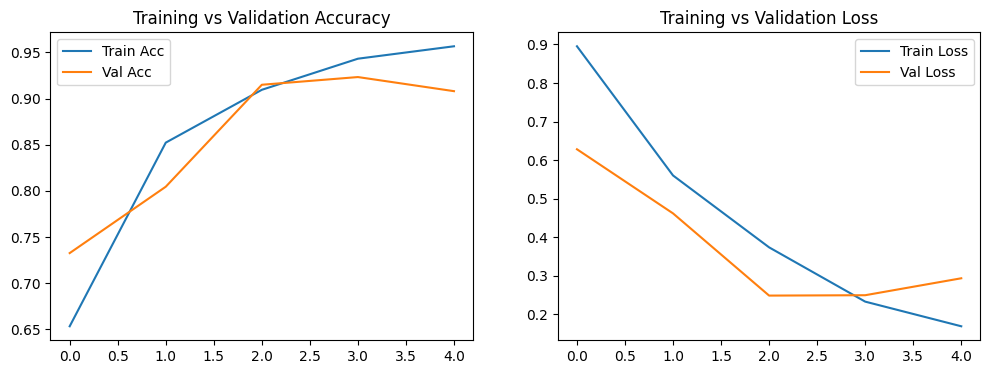

In [30]:
# Visualisasi hasil training
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

In [31]:
import pandas as pd
import numpy as np

# Prediksi probabilitas & label
y_pred_prob = model.predict([X_test_seq, X_test_tfidf])
y_pred = np.argmax(y_pred_prob, axis=1)

# Decode label
y_true_label = le.inverse_transform(y_test)
y_pred_label = le.inverse_transform(y_pred)

# Buat DataFrame untuk analisis
error_df = pd.DataFrame({
    'text': X_test,
    'true_label': y_true_label,
    'pred_label': y_pred_label
})

# Ambil contoh yang salah klasifikasi
errors = error_df[error_df['true_label'] != error_df['pred_label']]
print(f"Jumlah Kesalahan: {len(errors)} dari {len(error_df)} sampel\n")

# Tampilkan beberapa contoh
print(errors.sample(10, random_state=42))

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
Jumlah Kesalahan: 359 dari 3600 sampel

                                                   text true_label pred_label
2270  hi duolingo terima kasih aplikasi dunia gratis...   negative    neutral
403   ajar bahasa aplikasi part cerita temu bau lgbt...   negative   positive
2865  sungguh point heart biji olaho paksa usar paka...   negative   positive
3045  aplikasi duolingo bagus mantap best untung pil...   positive    neutral
540   fan banget duolingosistem game sampai tul² pah...    neutral   positive
2749  bagus banget ajar bahasa asing gampang obrol t...   positive    neutral
155           lancar bahasa inggrisd nilai thank memuch   positive    neutral
553                                      bahasa manfaat   positive    neutral
2518  dukung lgbt unit gambar pria rangkul pegang ta...   positive   negative
1225  aplikasi turut bantu orang ajar bahasa tampil ...   positive   negative


Tambahan Percobaan, Model CNN

In [32]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Data input
X = clean_df['text_akhir'].values
y = clean_df['polarity'].values

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Tokenizer & padding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_WORDS = 10000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_LEN)
X_test_seq  = pad_sequences(tokenizer.texts_to_sequences(X_test),  maxlen=MAX_LEN)

# Class weight (imbalance handling)
class_weight_dict = dict(enumerate(
    compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
))

In [33]:
# CNN Architecture
input_seq = Input(shape=(MAX_LEN,))
embed = Embedding(MAX_WORDS, 128)(input_seq)

# Convolutional layers
conv1 = Conv1D(128, 3, activation='relu')(embed)
pool1 = GlobalMaxPooling1D()(conv1)

dense1 = Dense(64, activation='relu')(pool1)
drop1 = Dropout(0.4)(dense1)

output = Dense(len(le.classes_), activation='softmax')(drop1)

model = Model(input_seq, output)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 98, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,337,731 (5.10 MB)

 Trainable params: 1,337,731 (5.10 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Training
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train_seq, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=128,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - accuracy: 0.4431 - loss: 0.9715 - val_accuracy: 0.8830 - val_loss: 0.3901
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.8613 - loss: 0.4941 - val_accuracy: 0.8882 - val_loss: 0.3437
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.9226 - loss: 0.2829 - val_accuracy: 0.9198 - val_loss: 0.2409
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.9579 - loss: 0.1540 - val_accuracy: 0.9139 - val_loss: 0.2572
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.9762 - loss: 0.0870 - val_accuracy: 0.9292 - val_loss: 0.2154
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.9856 - loss: 0.0480 - val_accuracy: 0.9292 - val_loss: 0.2507
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.9945 - loss: 0.0274 - val_accuracy: 0.9319 - val_loss: 0.2477
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.9961 - loss: 0.0166 - val_accura

In [35]:
# Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

test_loss, test_acc = model.evaluate(X_test_seq, y_test, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

y_pred_prob = model.predict(X_test_seq)
y_pred = np.argmax(y_pred_prob, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9263 - loss: 0.2461

Test Loss: 0.2365
Test Accuracy: 0.9300
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Classification Report:
              precision    recall  f1-score   support

    negative       0.66      0.59      0.63       204
     neutral       0.66      0.83      0.74       263
    positive       0.97      0.96      0.97      3133

    accuracy                           0.93      3600
   macro avg       0.77      0.79      0.78      3600
weighted avg       0.93      0.93      0.93      3600


Confusion Matrix:
[[ 121   38   45]
 [  10  218   35]
 [  52   72 3009]]


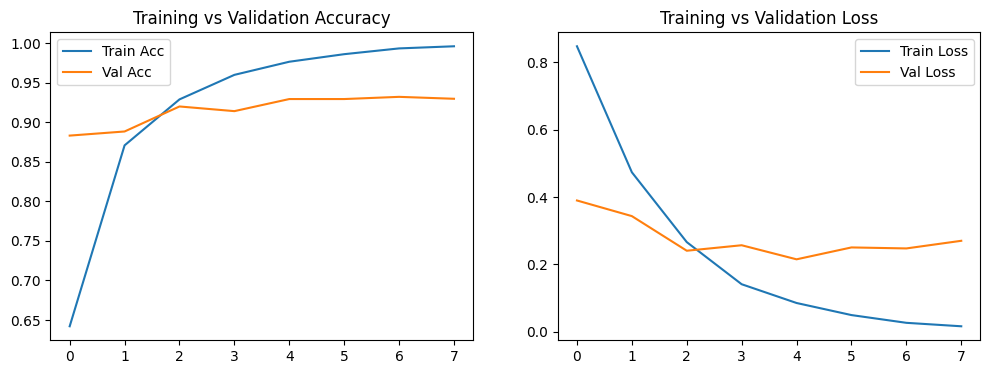

In [36]:
# Visualisasi hasil training
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

In [37]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_sentiment_cnn(text):
    cleaned = cleaningText(text)
    lowered = casefoldingText(cleaned)
    tokenized = tokenizingText(lowered)
    filtered = filteringText(tokenized)
    stemmed = stemmingText(filtered)
    cleaned_text = " ".join(stemmed.split())

    seq = pad_sequences(tokenizer.texts_to_sequences([cleaned_text]), maxlen=MAX_LEN)

    pred_prob = model.predict(seq)
    pred_class = np.argmax(pred_prob, axis=1)[0]
    label = le.inverse_transform([pred_class])[0]

    print("Teks Asli   :", text)
    print("Teks Bersih :", cleaned_text)
    print("Prediksi    :", label)
    print("Probabilitas:", pred_prob[0])

    return label, pred_prob

In [38]:
predict_sentiment_cnn("Duolingo keren banget fiturnya, ngebantu banget belajar bahasa!")
predict_sentiment_cnn("Aplikasinya sering error dan bikin kesel.")
predict_sentiment_cnn("Lumayan sih, tapi kadang loading lama.")
predict_sentiment_cnn("Tidak bagus tampilannya.")
predict_sentiment_cnn("Mantap banget aplikasi ini!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Teks Asli   : Duolingo keren banget fiturnya, ngebantu banget belajar bahasa!
Teks Bersih : duolingo keren banget fitur bantu banget ajar bahasa
Prediksi    : positive
Probabilitas: [8.066972e-06 1.994255e-03 9.979977e-01]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Teks Asli   : Aplikasinya sering error dan bikin kesel.
Teks Bersih : aplikasi error bikin kesel
Prediksi    : neutral
Probabilitas: [0.15449826 0.8309307  0.01457108]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Teks Asli   : Lumayan sih, tapi kadang loading lama.
Teks Bersih : lumayan kadang loading
Prediksi    : positive
Probabilitas: [5.7869381e-04 1.7153878e-02 9.8226744e-01]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Teks Asli   : Tidak bagus tampilannya.
Teks Bersih : bagus tampil
Prediksi    : positive
Probabilitas: [6.9560687e-04 7.6412655e-02 9.2289174e-01]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Teks Asli   : Mantap banget aplikasi ini!
Teks Bersih : mantap banget aplikasi
Prediksi    : positive

('positive',
 array([[4.5799210e-05, 6.3086720e-03, 9.9364555e-01]], dtype=float32))

In [39]:
!pip freeze > requirements.txt